# Brain Tumort MRI : Visualisation of the data and classification

Note : This notebook is an experimental work to understand and get along with classical methods and pipelines in data analysis and classification 

In [1]:
import sys
import os
import matplotlib.pyplot as plt

src_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
if src_path not in sys.path:
    sys.path.append(src_path)

from src.utils import plots, image_processing
from src.data import make_datasets

import torch
import torch.nn as nn

from src.model import SimpleCNN
from src.dataset import get_dataloaders
from src.train import epoch_optimization, epoch_validation, training_loop

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import cv2



/home/joh/miniconda3/envs/mri_tumor/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BASE_DIR = "../data"

df = make_datasets.create_inital_df(base_dir=BASE_DIR)
print(df)

                                                   path       label     split
0     /home/joh/Documents/school/projets/mri-classif...     notumor  training
1     /home/joh/Documents/school/projets/mri-classif...     notumor  training
2     /home/joh/Documents/school/projets/mri-classif...     notumor  training
3     /home/joh/Documents/school/projets/mri-classif...     notumor  training
4     /home/joh/Documents/school/projets/mri-classif...     notumor  training
...                                                 ...         ...       ...
7018  /home/joh/Documents/school/projets/mri-classif...  meningioma   testing
7019  /home/joh/Documents/school/projets/mri-classif...  meningioma   testing
7020  /home/joh/Documents/school/projets/mri-classif...  meningioma   testing
7021  /home/joh/Documents/school/projets/mri-classif...  meningioma   testing
7022  /home/joh/Documents/school/projets/mri-classif...  meningioma   testing

[7023 rows x 3 columns]


In [3]:
print(df['split'].unique())

['training' 'testing']


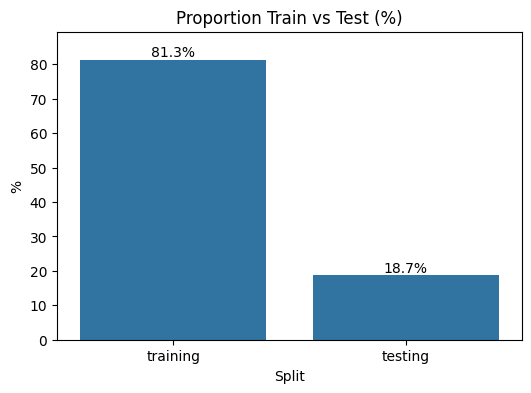

In [4]:
plots.plot_split_proportions(df)


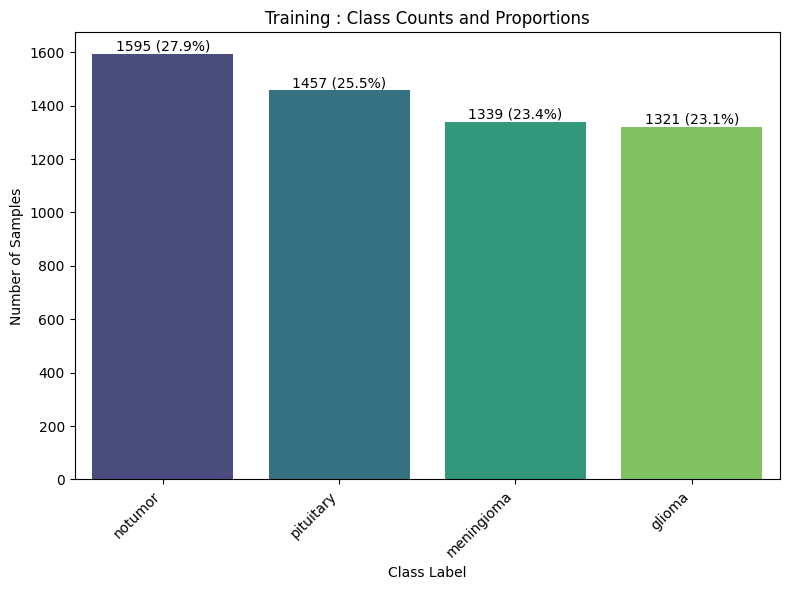

In [5]:
plots.plot_class_distribution(df, 'training')

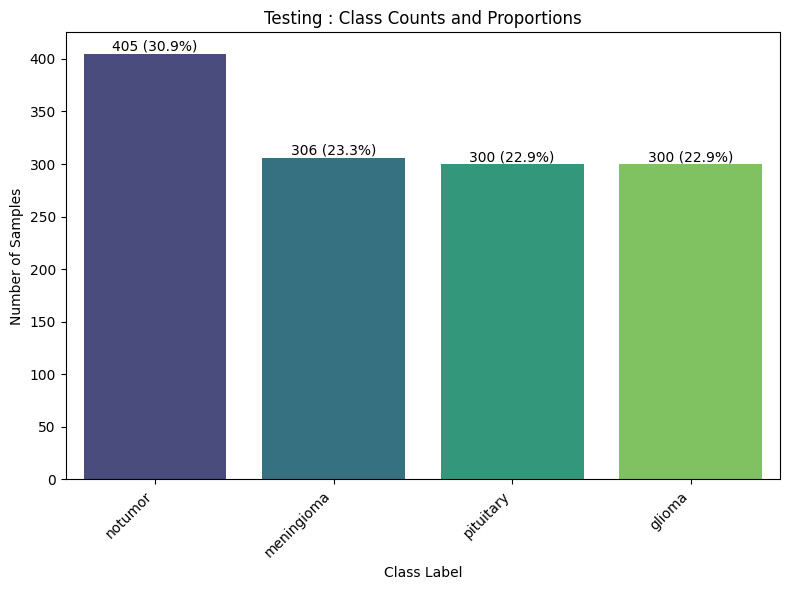

In [6]:
plots.plot_class_distribution(df, 'testing')

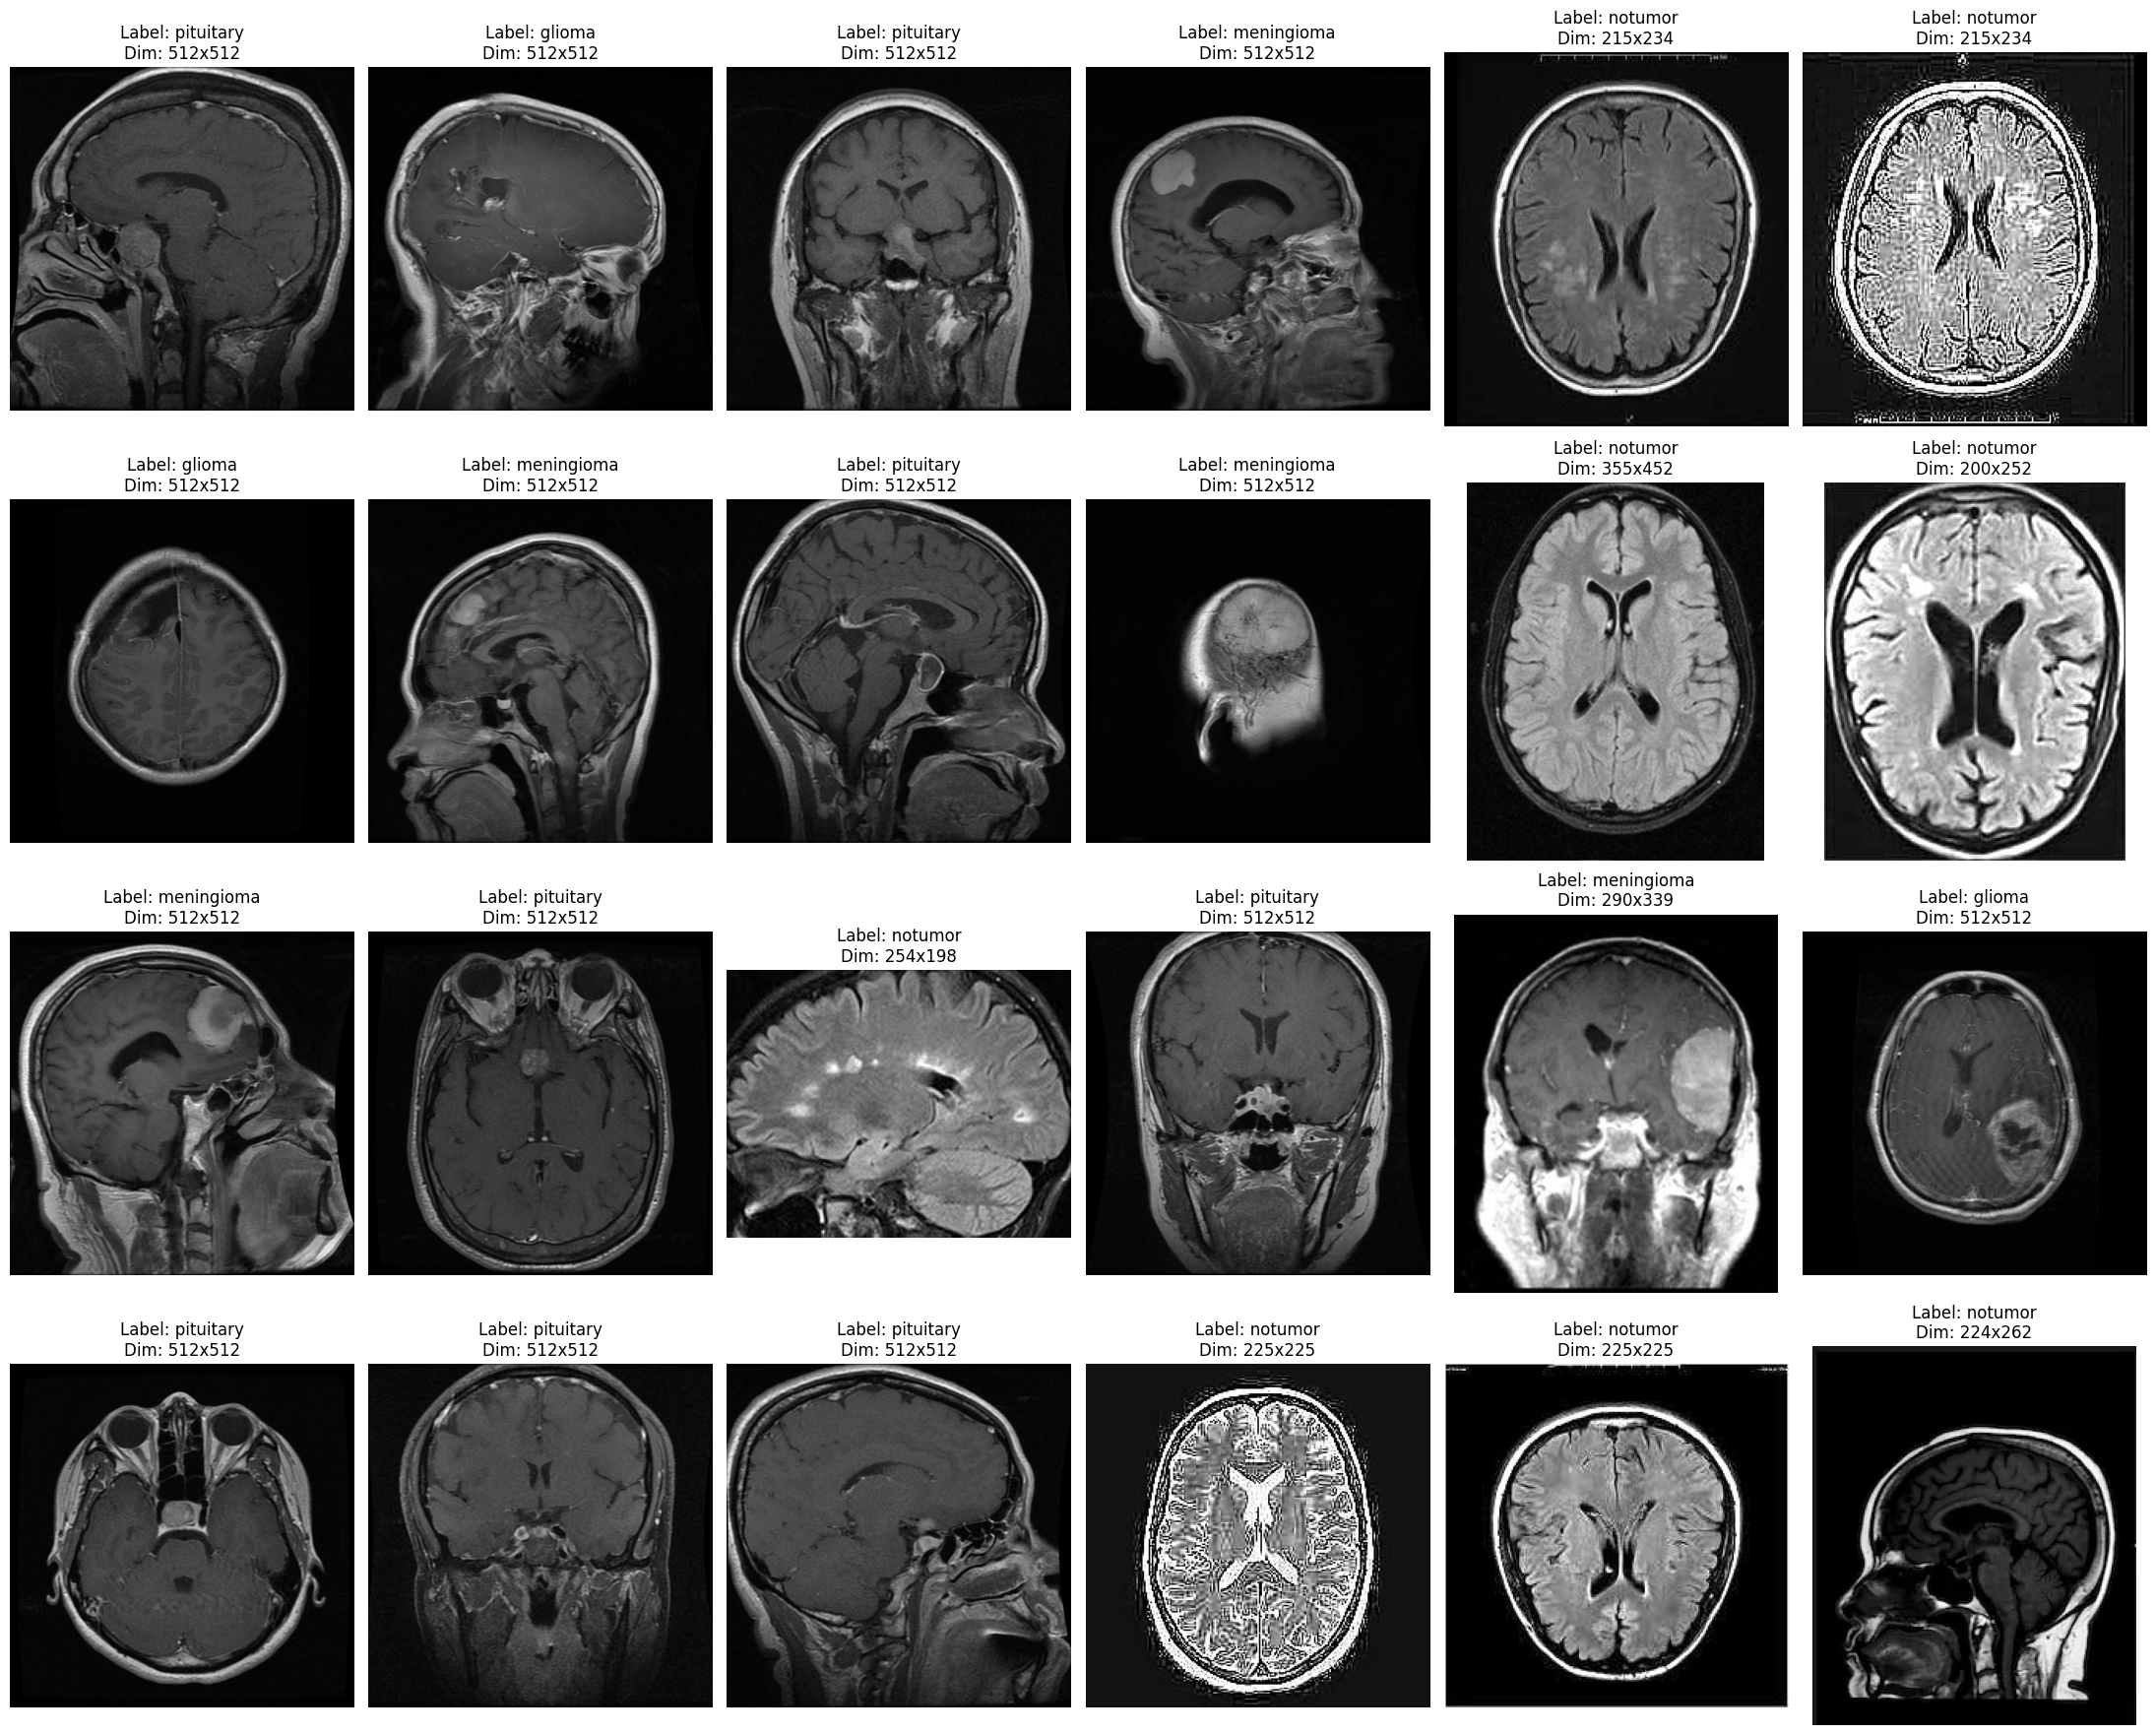

In [7]:
plots.plot_sample_images(df, n_samples=24)

In [8]:
df['width'] = df['path'].apply(lambda p: cv2.imread(p, cv2.IMREAD_GRAYSCALE).shape[1] if cv2.imread(p) is not None else np.nan)
df['height'] = df['path'].apply(lambda p: cv2.imread(p, cv2.IMREAD_GRAYSCALE).shape[0] if cv2.imread(p) is not None else np.nan)

print("Stats on dimension")
print(df[['width', 'height']].describe())


Stats on dimension
             width       height
count  7023.000000  7023.000000
mean    445.891499   448.346860
std     132.328035   126.282922
min     150.000000   168.000000
25%     393.000000   403.500000
50%     512.000000   512.000000
75%     512.000000   512.000000
max    1920.000000  1446.000000


In [9]:
SIZE = (150,150)

In [10]:
metrics_df = df['path'].apply(image_processing.extract_features)

In [11]:
df = pd.concat([df, metrics_df], axis=1)


In [12]:
print(df.head(10))

                                                path    label     split  \
0  /home/joh/Documents/school/projets/mri-classif...  notumor  training   
1  /home/joh/Documents/school/projets/mri-classif...  notumor  training   
2  /home/joh/Documents/school/projets/mri-classif...  notumor  training   
3  /home/joh/Documents/school/projets/mri-classif...  notumor  training   
4  /home/joh/Documents/school/projets/mri-classif...  notumor  training   
5  /home/joh/Documents/school/projets/mri-classif...  notumor  training   
6  /home/joh/Documents/school/projets/mri-classif...  notumor  training   
7  /home/joh/Documents/school/projets/mri-classif...  notumor  training   
8  /home/joh/Documents/school/projets/mri-classif...  notumor  training   
9  /home/joh/Documents/school/projets/mri-classif...  notumor  training   

   width  height        mean        std  skewness  kurtosis   entropy  \
0    235     214   74.493378  75.928388  0.577569 -0.858932  6.489984   
1    267     328  107.888474

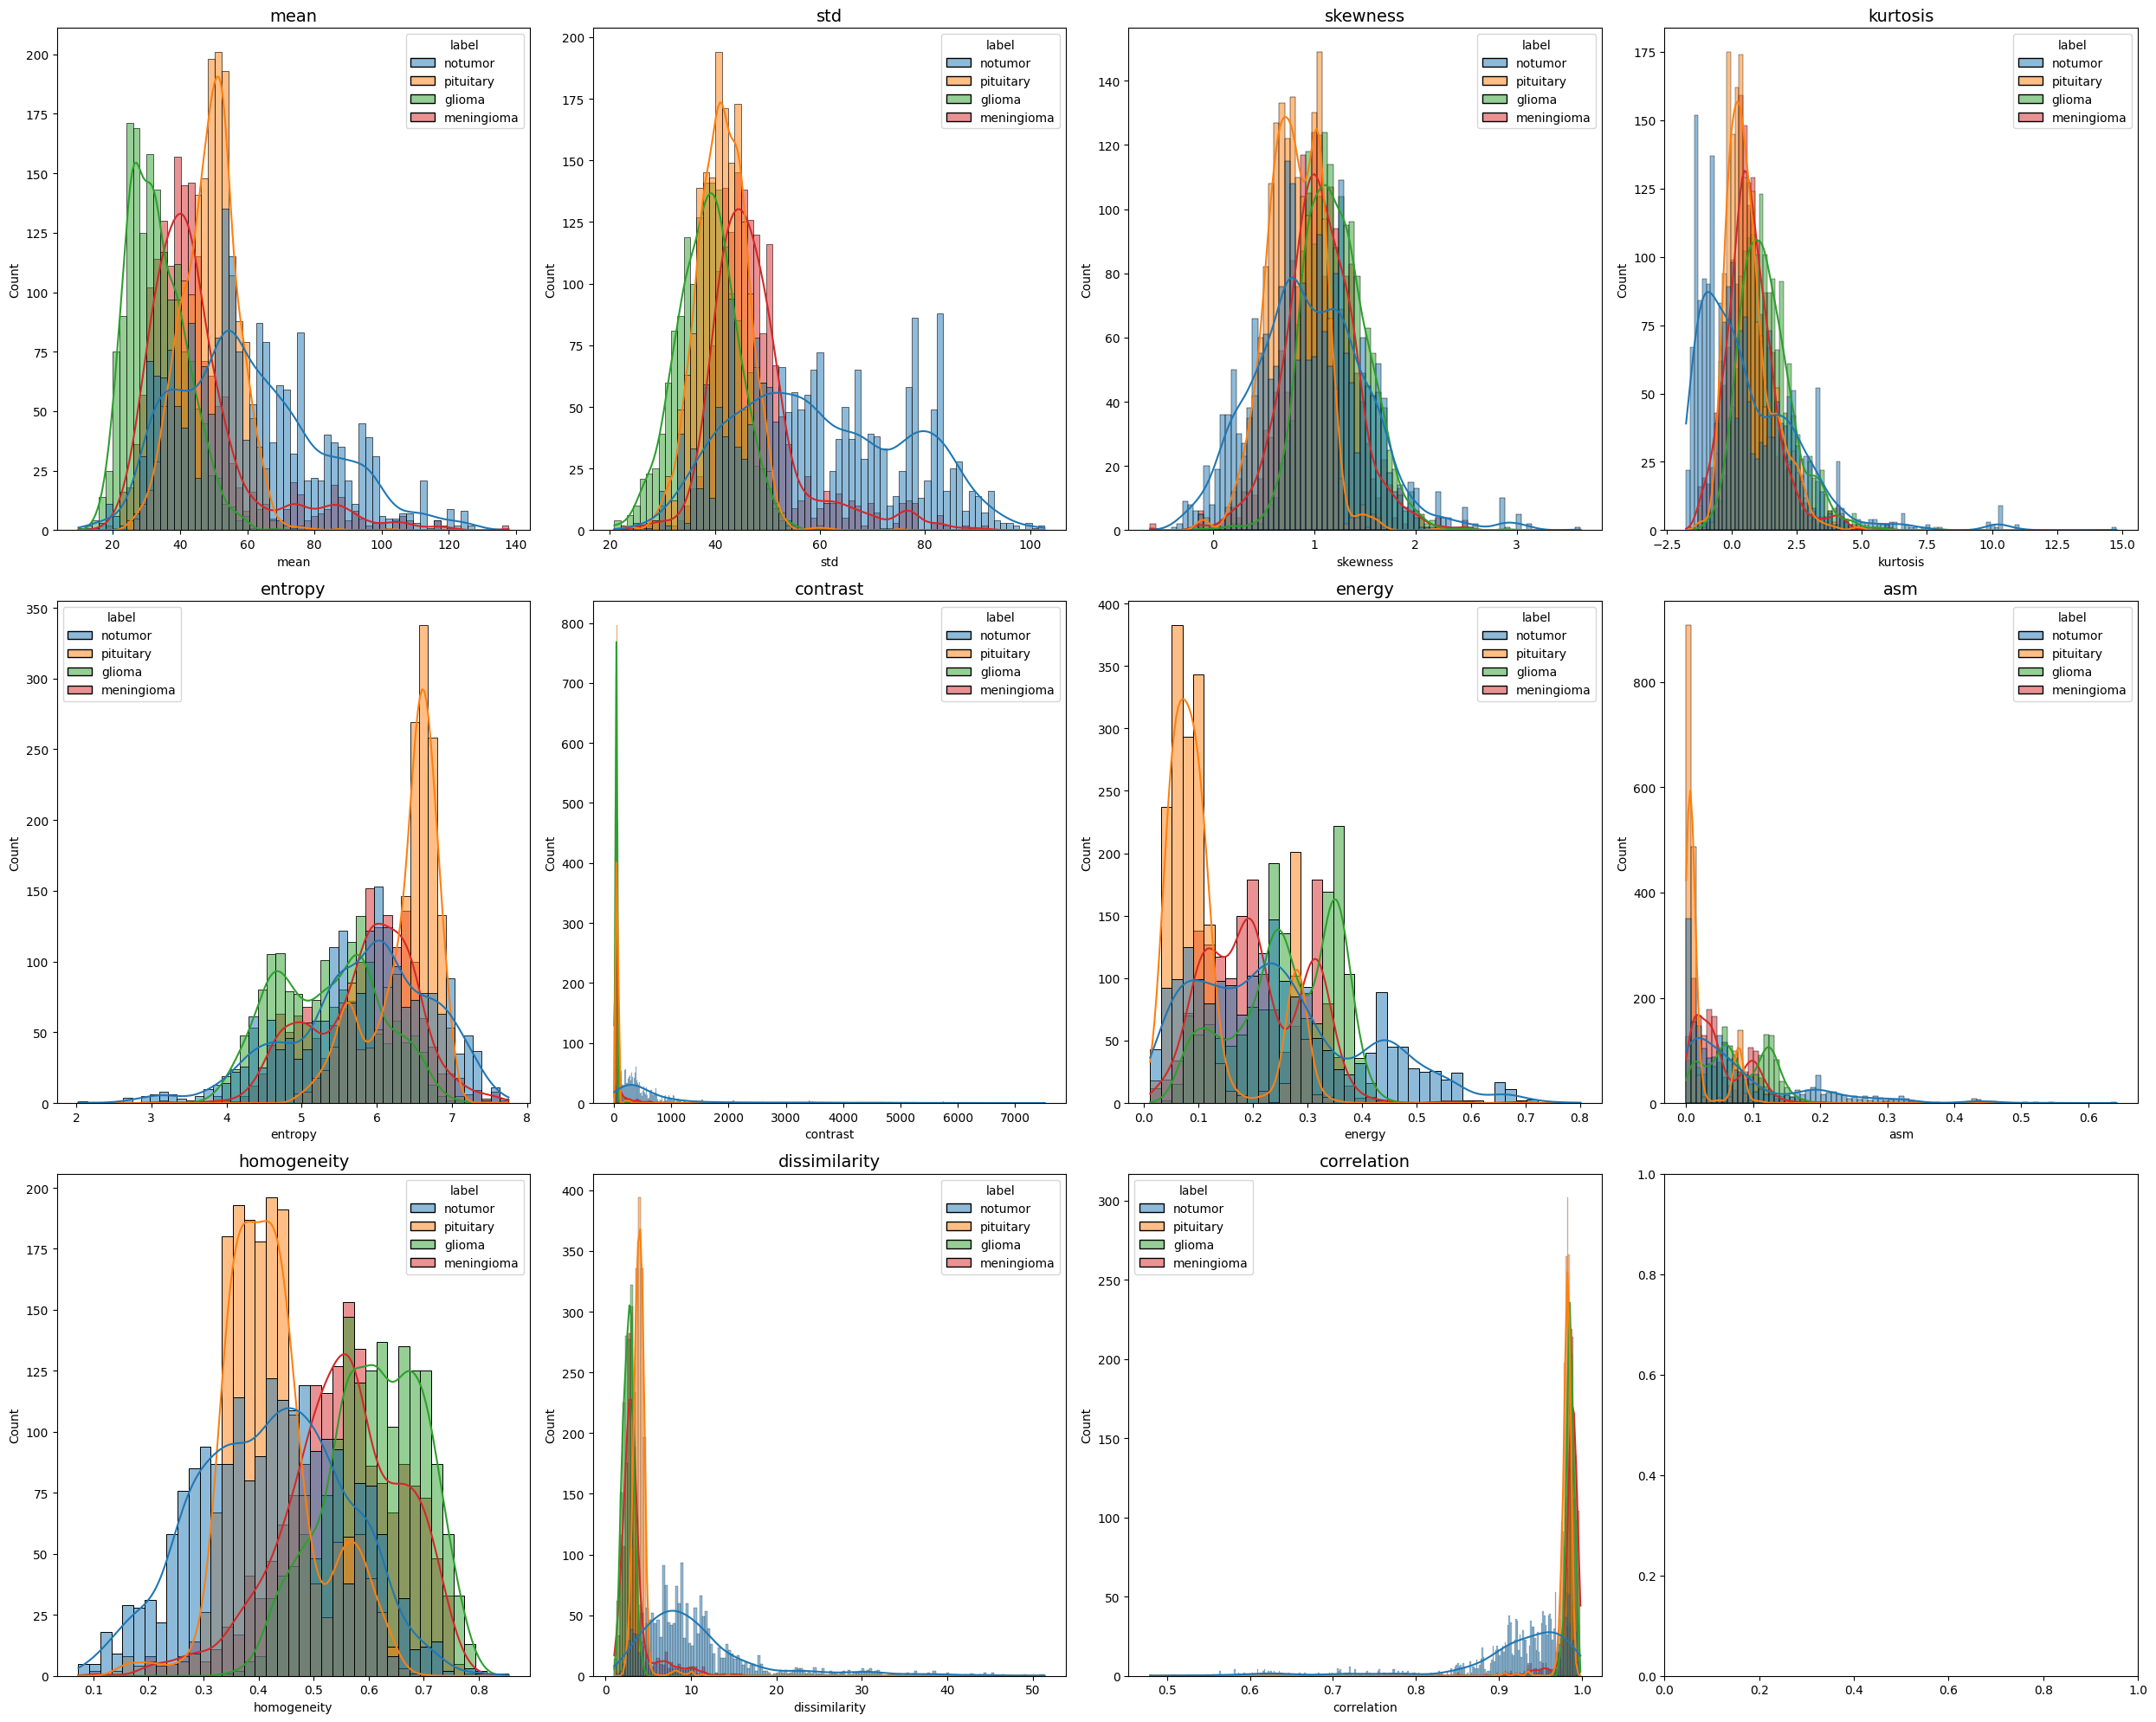

In [13]:
plots.plot_metrics(df)

In [14]:
tmp = df.head(3)
print(tmp)
print(tmp.values)
print(tmp.values.shape)

                                                path    label     split  \
0  /home/joh/Documents/school/projets/mri-classif...  notumor  training   
1  /home/joh/Documents/school/projets/mri-classif...  notumor  training   
2  /home/joh/Documents/school/projets/mri-classif...  notumor  training   

   width  height        mean        std  skewness  kurtosis   entropy  \
0    235     214   74.493378  75.928388  0.577569 -0.858932  6.489984   
1    267     328  107.888474  84.357195  0.057138 -1.462192  7.262369   
2    380     530   56.823694  70.974490  0.912530 -0.303276  4.802333   

      contrast    energy       asm  homogeneity  dissimilarity  correlation  
0  1556.370464  0.150997  0.022859     0.295544      22.276542     0.865059  
1   476.106614  0.038223  0.001461     0.142187      12.793642     0.966455  
2   594.779906  0.483886  0.234154     0.527419      10.604697     0.941031  
[['/home/joh/Documents/school/projets/mri-classifier/data/Training/notumor/Tr-no_0603.jpg'
  '

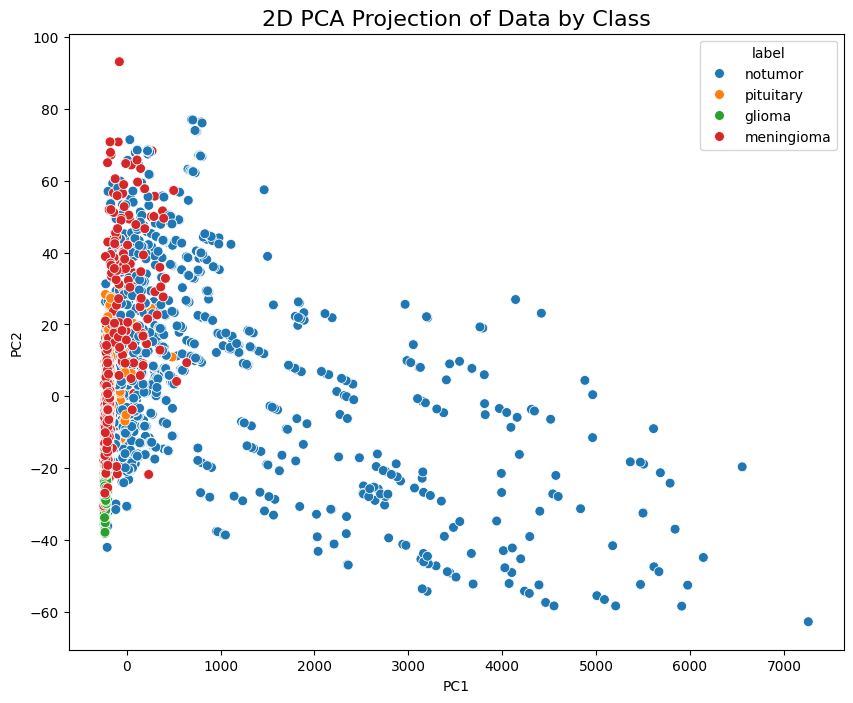

In [15]:
plots.plot_PCA(df)


In [16]:
BATCH_SIZE = 32
SIZE = (150,150)
SEED = 14
N_CLASSES = 4
lr = 1e-3
EPOCHS = 20

In [17]:
train_dir = BASE_DIR + r'/Training'
test_dir = BASE_DIR + r'/Testing'

In [18]:
train_loader, val_loader, test_loader = get_dataloaders(train_dir=train_dir, test_dir=test_dir, batch_size=BATCH_SIZE, size=SIZE, seed=SEED)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
model = SimpleCNN()
model.to(device)

SimpleCNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (10): ReLU()
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=3)
    (1): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

[INFO]: Epoch 1/20
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:36<00:00,  3.87it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:07<00:00,  5.61it/s]


	 Training Loss : 0.066, Training acc: 0.977
	 Validation Loss : 0.234, Validation Acc: 0.940
------------------------------------
[INFO]: Epoch 2/20
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:40<00:00,  3.55it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:06<00:00,  6.78it/s]


	 Training Loss : 0.032, Training acc: 0.990
	 Validation Loss : 0.225, Validation Acc: 0.952
------------------------------------
[INFO]: Epoch 3/20
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:41<00:00,  3.48it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:07<00:00,  5.78it/s]


	 Training Loss : 0.045, Training acc: 0.984
	 Validation Loss : 0.189, Validation Acc: 0.956
------------------------------------
[INFO]: Epoch 4/20
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:40<00:00,  3.53it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:07<00:00,  5.81it/s]


	 Training Loss : 0.034, Training acc: 0.987
	 Validation Loss : 0.264, Validation Acc: 0.934
------------------------------------
[INFO]: Epoch 5/20
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:40<00:00,  3.52it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:05<00:00,  6.92it/s]


	 Training Loss : 0.028, Training acc: 0.990
	 Validation Loss : 0.418, Validation Acc: 0.913
------------------------------------
[INFO]: Epoch 6/20
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:41<00:00,  3.46it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:05<00:00,  6.84it/s]


	 Training Loss : 0.019, Training acc: 0.994
	 Validation Loss : 0.230, Validation Acc: 0.951
------------------------------------
[INFO]: Epoch 7/20
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:38<00:00,  3.70it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:07<00:00,  5.80it/s]


	 Training Loss : 0.002, Training acc: 1.000
	 Validation Loss : 0.200, Validation Acc: 0.966
------------------------------------
[INFO]: Epoch 8/20
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:39<00:00,  3.60it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:06<00:00,  6.20it/s]


	 Training Loss : 0.000, Training acc: 1.000
	 Validation Loss : 0.234, Validation Acc: 0.961
------------------------------------
[INFO]: Epoch 9/20
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:38<00:00,  3.75it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:06<00:00,  6.06it/s]


	 Training Loss : 0.000, Training acc: 1.000
	 Validation Loss : 0.240, Validation Acc: 0.959
------------------------------------
[INFO]: Epoch 10/20
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:40<00:00,  3.52it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:06<00:00,  5.92it/s]


	 Training Loss : 0.000, Training acc: 1.000
	 Validation Loss : 0.242, Validation Acc: 0.958
------------------------------------
[INFO]: Epoch 11/20
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:39<00:00,  3.62it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:07<00:00,  5.66it/s]


	 Training Loss : 0.000, Training acc: 1.000
	 Validation Loss : 0.248, Validation Acc: 0.960
------------------------------------
[INFO]: Epoch 12/20
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:41<00:00,  3.45it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:06<00:00,  6.59it/s]


	 Training Loss : 0.000, Training acc: 1.000
	 Validation Loss : 0.259, Validation Acc: 0.959
------------------------------------
[INFO]: Epoch 13/20
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:40<00:00,  3.54it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:06<00:00,  6.48it/s]


	 Training Loss : 0.000, Training acc: 1.000
	 Validation Loss : 0.261, Validation Acc: 0.960
------------------------------------
[INFO]: Epoch 14/20
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:37<00:00,  3.77it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:05<00:00,  7.15it/s]


	 Training Loss : 0.000, Training acc: 1.000
	 Validation Loss : 0.264, Validation Acc: 0.960
------------------------------------
[INFO]: Epoch 15/20
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:38<00:00,  3.70it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:07<00:00,  5.68it/s]


	 Training Loss : 0.000, Training acc: 1.000
	 Validation Loss : 0.272, Validation Acc: 0.960
------------------------------------
[INFO]: Epoch 16/20
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:41<00:00,  3.45it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:06<00:00,  6.46it/s]


	 Training Loss : 0.000, Training acc: 1.000
	 Validation Loss : 0.269, Validation Acc: 0.961
------------------------------------
[INFO]: Epoch 17/20
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:40<00:00,  3.57it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:07<00:00,  5.79it/s]


	 Training Loss : 0.000, Training acc: 1.000
	 Validation Loss : 0.275, Validation Acc: 0.959
------------------------------------
[INFO]: Epoch 18/20
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:38<00:00,  3.72it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:07<00:00,  5.77it/s]


	 Training Loss : 0.000, Training acc: 1.000
	 Validation Loss : 0.278, Validation Acc: 0.960
------------------------------------
[INFO]: Epoch 19/20
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:38<00:00,  3.71it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:06<00:00,  6.00it/s]


	 Training Loss : 0.000, Training acc: 1.000
	 Validation Loss : 0.276, Validation Acc: 0.960
------------------------------------
[INFO]: Epoch 20/20
Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:42<00:00,  3.37it/s]


Validation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:06<00:00,  6.22it/s]


	 Training Loss : 0.000, Training acc: 1.000
	 Validation Loss : 0.287, Validation Acc: 0.960
------------------------------------


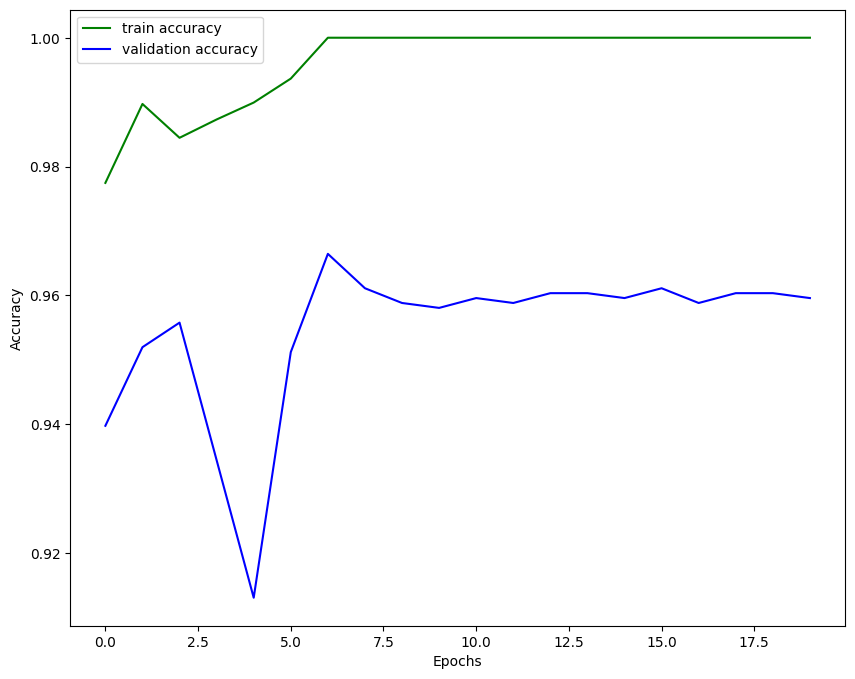

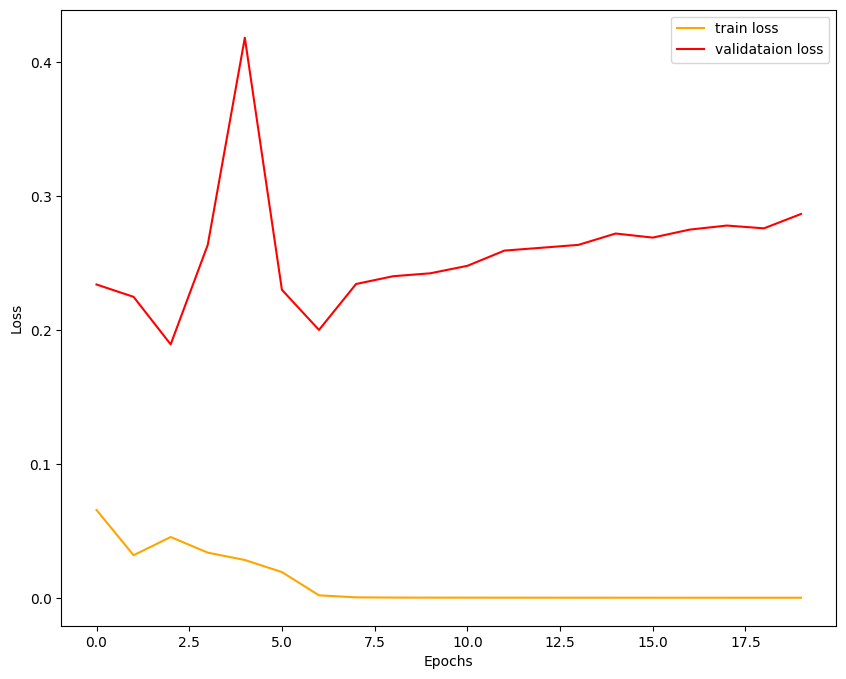

In [25]:
train_acc, val_acc, train_loss, val_loss = training_loop(EPOCHS, model, device, criterion, optimizer, train_loader, test_loader)